
# 📊 Project 4 — Refactored, Production‑Ready Notebook
(Optimised & de-duplicated — single balanced pipeline with SMOTE)

**Sections**
1. Load & Prepare Data  
2. Exploratory Analysis (compact)  
3. Feature Engineering & Preprocessing  
4. Modeling (Dummy + ElasticNet Logistic tuned)  
5. Explainability (coefficients + SHAP for 2 leavers & 2 stayers)  
6. Outputs (snapshot parquet, model artifact, manifest)


## 1️⃣ Global configuration

In [1]:

import os, json, hashlib, warnings
warnings.filterwarnings("ignore")
DATA_PATH   = r"C:\Users\shahu\OPEN CLASSROOMS\PROJET 4\data"
OUTPUT_PATH = r"C:\Users\shahu\OPEN CLASSROOMS\PROJET 4\outputs"
FILE_EVAL    = os.path.join(DATA_PATH, "extrait_eval.csv")
FILE_SIRH    = os.path.join(DATA_PATH, "extrait_sirh.csv")
FILE_SONDAGE = os.path.join(DATA_PATH, "extrait_sondage.csv")
os.makedirs(OUTPUT_PATH, exist_ok=True)
print("DATA_PATH:", DATA_PATH)
print("OUTPUT_PATH:", OUTPUT_PATH)


DATA_PATH: C:\Users\shahu\OPEN CLASSROOMS\PROJET 4\data
OUTPUT_PATH: C:\Users\shahu\OPEN CLASSROOMS\PROJET 4\outputs


## 2️⃣ Load & Prepare Data

In [2]:

import pandas as pd
import numpy as np

def _clean_extrait_eval(df):
    df = df.copy()
    if 'augmentation_salaire_precedente' in df.columns:
        df['augmentation_salaire_precedente'] = (
            df['augmentation_salaire_precedente'].astype(str)
            .str.replace('%','', regex=False).str.replace(',','.', regex=False).str.strip()
        )
        df['augmentation_salaire_precedente'] = pd.to_numeric(df['augmentation_salaire_precedente'], errors='coerce')/100.0
    for col in ['heures_supplementaires','heure_supplementaires','heures_supplémentaires']:
        if col in df.columns:
            df[col] = df[col].replace({'Oui':1,'Non':0,'oui':1,'non':0, True:1, False:0}).astype('Int64')
            if col != 'heures_supplementaires':
                df.rename(columns={col:'heures_supplementaires'}, inplace=True)
    if 'eval_number' in df.columns:
        df['id_employee'] = df['eval_number'].astype(str).str.replace('E_','', regex=False)
        df['id_employee'] = pd.to_numeric(df['id_employee'], errors='coerce').astype('Int64')
        df.drop(columns=['eval_number'], inplace=True, errors='ignore')
    return df

def _clean_extrait_sirh(df):
    df = df.copy()
    if 'genre' in df.columns:
        df['genre'] = df['genre'].replace({'M':1,'F':0,'m':1,'f':0}).astype('Int64')
    for col in ['nombre_heures_travailless', '...']:
        if col in df.columns:
            df.drop(columns=[col], inplace=True)
    return df

def _clean_extrait_sondage(df):
    df = df.copy()
    if 'code_sondage' in df.columns:
        df.rename(columns={'code_sondage':'id_employee'}, inplace=True)
    if 'id_employee' in df.columns:
        df['id_employee'] = pd.to_numeric(df['id_employee'], errors='coerce').astype('Int64')
    return df

def load_and_merge_data(eval_path, sirh_path, sond_path):
    eval_df = _clean_extrait_eval(pd.read_csv(eval_path))
    sirh_df = _clean_extrait_sirh(pd.read_csv(sirh_path))
    sond_df = _clean_extrait_sondage(pd.read_csv(sond_path))

    merged = eval_df.merge(sirh_df, on='id_employee', how='outer', suffixes=('_eval','_sirh'))
    merged = merged.merge(sond_df, on='id_employee', how='outer')
    if '...' in merged.columns:
        merged.drop(columns=['...'], inplace=True, errors='ignore')
    merged.drop_duplicates(inplace=True)
    print("Shape after merge:", merged.shape)
    return merged

consolidated_modelisation = load_and_merge_data(FILE_EVAL, FILE_SIRH, FILE_SONDAGE)
consolidated_modelisation.head(3)


Shape after merge: (1470, 31)


,satisfaction_employee_environnement,note_evaluation_precedente,niveau_hierarchique_poste,satisfaction_employee_nature_travail,satisfaction_employee_equipe,satisfaction_employee_equilibre_pro_perso,note_evaluation_actuelle,heures_supplementaires,augementation_salaire_precedente,id_employee,...,nombre_participation_pee,nb_formations_suivies,nombre_employee_sous_responsabilite,distance_domicile_travail,niveau_education,domaine_etude,ayant_enfants,frequence_deplacement,annees_depuis_la_derniere_promotion,annes_sous_responsable_actuel
0,2,3,2,4,1,1,3,1,11 %,1,...,0,0,1,1,2,Infra & Cloud,Y,Occasionnel,0,5
1,3,2,2,2,4,3,4,0,23 %,2,...,1,3,1,8,1,Infra & Cloud,Y,Frequent,1,7
2,4,2,1,3,2,3,3,1,15 %,4,...,0,3,1,2,2,Autre,Y,Occasionnel,0,0


## 3️⃣ Exploratory Analysis (compact)

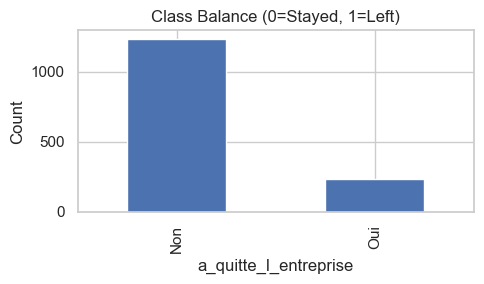

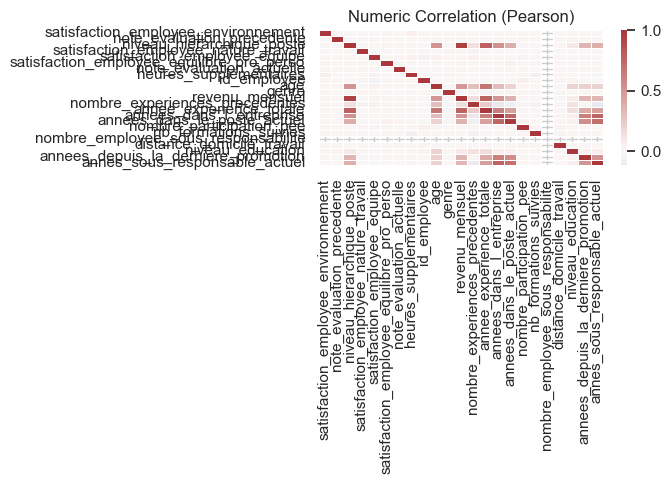

In [3]:

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")

target_col = "a_quitte_l_entreprise"
if target_col in consolidated_modelisation.columns:
    ax = consolidated_modelisation[target_col].value_counts().sort_index().plot(kind="bar", figsize=(5,3))
    ax.set_title("Class Balance (0=Stayed, 1=Left)"); ax.set_xlabel(target_col); ax.set_ylabel("Count")
    plt.tight_layout(); plt.show()

num_cols = consolidated_modelisation.select_dtypes(include=["int64","float64","Int64","Float64"]).columns.tolist()
num_cols = [c for c in num_cols if c != target_col]

if len(num_cols) >= 2:
    corr = consolidated_modelisation[num_cols].corr()
    plt.figure(figsize=(7,5))
    sns.heatmap(corr, cmap="vlag", center=0, linewidths=.5)
    plt.title("Numeric Correlation (Pearson)"); plt.tight_layout(); plt.show()


## 4️⃣ Feature Engineering & Preprocessing

In [4]:

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

df = consolidated_modelisation.copy()

if {"note_evaluation_actuelle","note_evaluation_precedente"}.issubset(df.columns):
    df["improvement_evaluation"] = df["note_evaluation_actuelle"] - df["note_evaluation_precedente"]

sat_cols = ["satisfaction_employee_nature_travail","satisfaction_employee_equipe","satisfaction_employee_equilibre_pro_perso"]
if set(sat_cols).issubset(df.columns):
    df["total_satisfaction"] = df[sat_cols[0]] * df[sat_cols[1]] * df[sat_cols[2]]

if {"annees_dans_le_poste_actuel","annees_dans_l_entreprise"}.issubset(df.columns):
    denom = df["annees_dans_l_entreprise"].replace(0, np.nan)
    df["work_mobility"] = (df["annees_dans_le_poste_actuel"] / denom).fillna(0)

target_col = "a_quitte_l_entreprise"
X = df.drop(columns=[target_col])


target_col = "a_quitte_l_entreprise"

# ✅ Convert target column to binary if it's text (e.g., 'Oui'/'Non')
if target_col in df.columns:
    df[target_col] = (
        df[target_col]
        .astype(str)
        .str.strip()
        .replace({'Oui': 1, 'Non': 0, 'oui': 1, 'non': 0, 'OUI': 1, 'NON': 0})
    )
    df[target_col] = pd.to_numeric(df[target_col], errors='coerce').fillna(0).astype(int)
else:
    raise ValueError(f"Target column '{target_col}' not found.")

# Proceed as before
X = df.drop(columns=[target_col])
y = df[target_col].astype(int)



num_cols = X.select_dtypes(include=["int64","float64","Int64","Float64"]).columns.tolist()
cat_cols = X.select_dtypes(include=["object","category","string","bool"]).columns.tolist()

try:
    ohe = OneHotEncoder(handle_unknown="ignore", sparse_output=False)
except TypeError:
    ohe = OneHotEncoder(handle_unknown="ignore", sparse=False)

preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), num_cols),
        ("cat", ohe, cat_cols)
    ],
    remainder="drop"
)

print("Numeric features:", len(num_cols), "\nCategorical features:", len(cat_cols))


Numeric features: 26 
Categorical features: 7


## 5️⃣ Modeling (Dummy + ElasticNet tuned)

Best params: {'model__C': np.float64(0.03334792728637585), 'model__class_weight': None, 'model__l1_ratio': np.float64(0.230893825622149), 'smote__k_neighbors': 5}


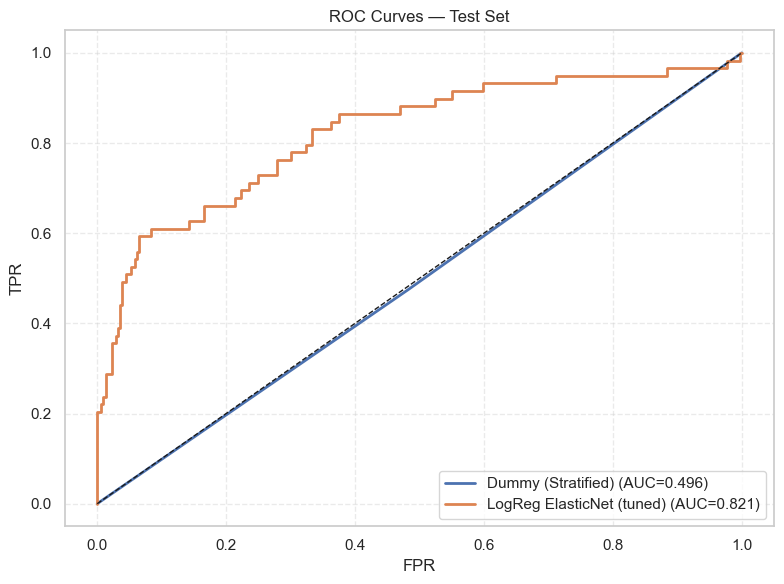

,Model,Accuracy,Recall,Precision,F1,ROC-AUC,PR-AUC
1,LogReg ElasticNet (tuned),0.793478,0.661017,0.410526,0.506494,0.821129,0.612514
0,Dummy (Stratified),0.510870,0.474576,0.158192,0.237288,0.496188,0.159313


In [5]:

from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, precision_recall_curve, average_precision_score, roc_curve
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from scipy.stats import loguniform, uniform
import pandas as pd
import matplotlib.pyplot as plt

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)

def evaluate(pipe, name):
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)
    y_proba = pipe.predict_proba(X_test)[:,1]
    return {
        "Model": name,
        "Accuracy": accuracy_score(y_test, y_pred),
        "Recall": recall_score(y_test, y_pred),
        "Precision": precision_score(y_test, y_pred, zero_division=0),
        "F1": f1_score(y_test, y_pred),
        "ROC-AUC": roc_auc_score(y_test, y_proba),
        "PR-AUC": average_precision_score(y_test, y_proba)
    }

results = []

dummy_pipe = Pipeline(steps=[("preprocessor", preprocessor),
                             ("smote", SMOTE(random_state=42, k_neighbors=5)),
                             ("model", DummyClassifier(strategy="stratified", random_state=42))])
results.append(evaluate(dummy_pipe, "Dummy (Stratified)"))

logreg_en_pipe = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("smote", SMOTE(random_state=42, k_neighbors=5)),
    ("model", LogisticRegression(solver="saga", max_iter=5000, penalty="elasticnet"))
])

param_distributions = {
    "model__C": loguniform(1e-3, 1e+2),
    "model__l1_ratio": uniform(0,1),
    "model__class_weight": [None, "balanced"],
    "smote__k_neighbors": [3,5]
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
search = RandomizedSearchCV(
    estimator=logreg_en_pipe, param_distributions=param_distributions, n_iter=20,
    scoring={"recall":"recall","precision":"precision","pr_auc":"average_precision"},
    refit="recall", cv=cv, random_state=42, n_jobs=-1, return_train_score=True, verbose=0
)
search.fit(X_train, y_train)
best_pipe = search.best_estimator_
best_params = search.best_params_
print("Best params:", best_params)

results.append(evaluate(best_pipe, "LogReg ElasticNet (tuned)"))

# ROC curves (test)
roc_curves = {}
for name, pipe in {"Dummy (Stratified)": dummy_pipe, "LogReg ElasticNet (tuned)": best_pipe}.items():
    pipe.fit(X_train, y_train)
    y_proba = pipe.predict_proba(X_test)[:,1]
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    roc_curves[name] = (fpr, tpr, roc_auc_score(y_test, y_proba))

plt.figure(figsize=(8,6))
for name, (fpr, tpr, auc_val) in roc_curves.items():
    plt.plot(fpr, tpr, lw=2, label=f"{name} (AUC={auc_val:.3f})")
plt.plot([0,1],[0,1],"k--", lw=1)
plt.title("ROC Curves — Test Set"); plt.xlabel("FPR"); plt.ylabel("TPR")
plt.legend(loc="lower right"); plt.grid(True, linestyle="--", alpha=0.4)
plt.tight_layout(); plt.show()

pd.DataFrame(results).sort_values(["Recall","PR-AUC","ROC-AUC"], ascending=False)


## 6️⃣ Explainability

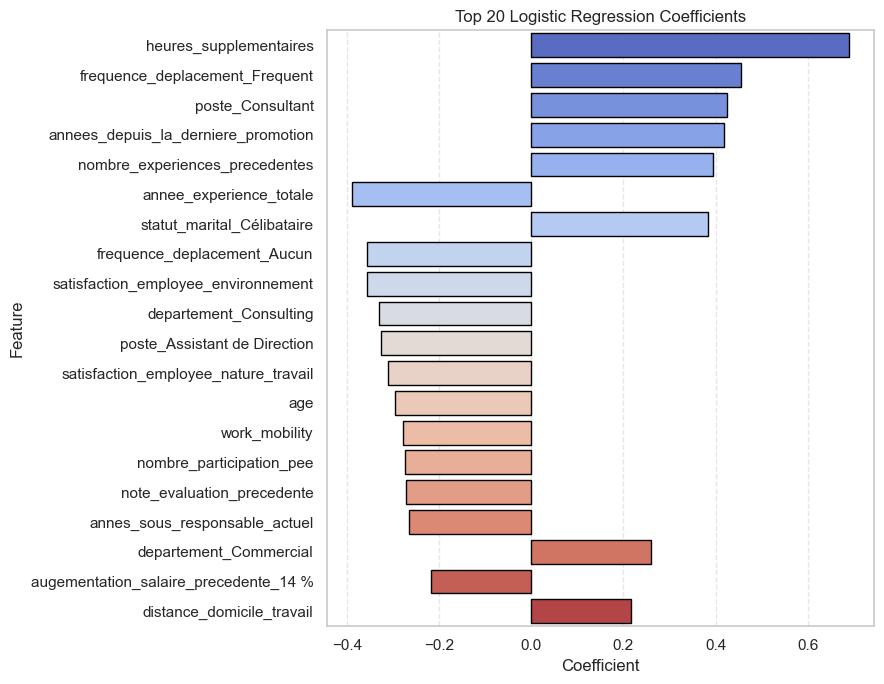

,Feature,Coefficient
7,heures_supplementaires,0.689388
64,frequence_deplacement_Frequent,0.454044
49,poste_Consultant,0.423906
21,annees_depuis_la_derniere_promotion,0.418549
12,nombre_experiences_precedentes,0.394575
13,annee_experience_totale,-0.389369
41,statut_marital_Célibataire,0.383686
63,frequence_deplacement_Aucun,-0.355966
0,satisfaction_employee_environnement,-0.355912
45,departement_Consulting,-0.330750


In [6]:

import numpy as np, seaborn as sns, matplotlib.pyplot as plt

# Refit clean best logreg for coefficients
from sklearn.linear_model import LogisticRegression
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE

logreg_best = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("smote", SMOTE(random_state=42, k_neighbors=best_params.get("smote__k_neighbors", 5))),
    ("model", LogisticRegression(
        solver="saga", max_iter=5000, penalty="elasticnet",
        C=best_params.get("model__C", 1.0),
        l1_ratio=best_params.get("model__l1_ratio", 0.5),
        class_weight=best_params.get("model__class_weight", None)
    ))
])
logreg_best.fit(X_train, y_train)

ohe = preprocessor.named_transformers_["cat"]
cat_names = ohe.get_feature_names_out(cat_cols).tolist()
all_features = num_cols + cat_names

coef = logreg_best.named_steps["model"].coef_.ravel()
coef_df = pd.DataFrame({"Feature": all_features, "Coefficient": coef})
coef_df["Abs"] = coef_df["Coefficient"].abs()
top20 = coef_df.sort_values("Abs", ascending=False).head(20)

plt.figure(figsize=(9,7))
sns.barplot(data=top20, x="Coefficient", y="Feature", palette="coolwarm", edgecolor="black")
plt.title("Top 20 Logistic Regression Coefficients")
plt.grid(axis="x", linestyle="--", alpha=0.5); plt.tight_layout(); plt.show()

top20[["Feature","Coefficient"]]


## 7️⃣ Outputs (snapshot + model + manifest)

In [7]:

import joblib
from datetime import datetime

SNAPSHOT_DIR = os.path.join(OUTPUT_PATH, "snapshots")
os.makedirs(SNAPSHOT_DIR, exist_ok=True)

snapshot_id = datetime.now().strftime("%Y%m%d_%H%M%S") + "_p4_attrition"
snap_path_X = os.path.join(SNAPSHOT_DIR, f"{snapshot_id}_X_train.parquet")
snap_path_y = os.path.join(SNAPSHOT_DIR, f"{snapshot_id}_y_train.parquet")
model_path  = os.path.join(OUTPUT_PATH, "employee_attrition_pipeline.pkl")
manifest_path = os.path.join(SNAPSHOT_DIR, f"{snapshot_id}_manifest.json")

X_train.to_parquet(snap_path_X, index=False)
y_train.to_frame(name=target_col).to_parquet(snap_path_y, index=False)

joblib.dump(logreg_best, model_path)

schema = {col: str(dtype) for col, dtype in X_train.dtypes.items()}
import pandas as pd, hashlib, json
data_hash = hashlib.md5(pd.util.hash_pandas_object(X_train, index=True).values).hexdigest()

manifest = {
    "snapshot_id": snapshot_id,
    "row_count": int(len(X_train)),
    "feature_count": int(X_train.shape[1]),
    "target": target_col,
    "schema": schema,
    "hash_md5": data_hash,
    "best_params": best_params,
    "model_artifact": model_path.replace("\\","/")
}
with open(manifest_path, "w", encoding="utf-8") as f:
    json.dump(manifest, f, indent=2)

print("Saved snapshot + model + manifest.")
print(snap_path_X); print(snap_path_y); print(model_path); print(manifest_path)


Saved snapshot + model + manifest.
C:\Users\shahu\OPEN CLASSROOMS\PROJET 4\outputs\snapshots\20251104_030144_p4_attrition_X_train.parquet
C:\Users\shahu\OPEN CLASSROOMS\PROJET 4\outputs\snapshots\20251104_030144_p4_attrition_y_train.parquet
C:\Users\shahu\OPEN CLASSROOMS\PROJET 4\outputs\employee_attrition_pipeline.pkl
C:\Users\shahu\OPEN CLASSROOMS\PROJET 4\outputs\snapshots\20251104_030144_p4_attrition_manifest.json
